In [ ]:
# In this notebook, I would use avalon fingerprints to develop predictive models for molecular property (energy gap)

# 1. HOMO-LUMO energy gap prediction

In [ ]:
!!pip install rdkit-pypi==2023.3.1b1

['Collecting rdkit-pypi==2023.3.1b1',
 '  Downloading rdkit_pypi-2023.3.1b1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.11/dist-packages (from rdkit-pypi==2023.3.1b1) (1.26.4)',
 'Requirement already satisfied: Pillow in /usr/local/lib/python3.11/dist-packages (from rdkit-pypi==2023.3.1b1) (11.1.0)',
 'Downloading rdkit_pypi-2023.3.1b1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.7 MB)',
 '\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/29.7 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.1/29.7 MB\x1b \x1b3.7 MB/s\x1b eta \x1b0:00:08\x1b',
 '\x1b[2K   \x1b━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.1/29.7 MB\x1b \x1b15.7 MB/s\x1b eta \x1b0:00:02\x1b',
 '\x1b[2K   \x1b━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b5.1/29.7 MB\x1b \x1b49.2 MB/s\x1b eta 

In [ ]:
!pip install lightgbm
!pip install dask[dataframe]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs

#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor

In [ ]:
dataset = pd.read_csv('Orbital_Energies_input_data.csv')
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


In [ ]:
# To display the last 5 rows

dataset.tail ()


,SMILES,Energygap
2899,C(CP(c1ccccc1)c1ccccc1)P(c1ccccc1)c1ccccc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCO[C@H]1C=Cc2ccccc2N1C(=O)OCC,165.098245
2902,s1ccc2ccccc12,167.958431
2903,Cc1cccc(C)c1O,188.369417


In [ ]:
# Now lets generate 2D structures of the molecules. These are called mol representation.

PandasTools.AddMoleculeColumnToFrame(dataset,'SMILES','Structure', includeFingerprints=True)

Failed to patch pandas - unable to change molecule rendering


In [ ]:
dataset.head()

,SMILES,Energygap,Structure
0,Cc1ccc(cc1)C(F)(F)F,197.749421,<rdkit.Chem.rdchem.Mol object at 0x7c44e4dd4ac0>
1,OC(=O)CCCCl,247.493942,<rdkit.Chem.rdchem.Mol object at 0x7c44e4dd4c80>
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327,<rdkit.Chem.rdchem.Mol object at 0x7c44e4dd4d60>
3,Nc1ccc(Cl)c(Cl)c1,169.027707,<rdkit.Chem.rdchem.Mol object at 0x7c44e4dd4f90>
4,C[C@@H](CCO)CCC=C(C)C,209.569808,<rdkit.Chem.rdchem.Mol object at 0x7c44e4dd5000>


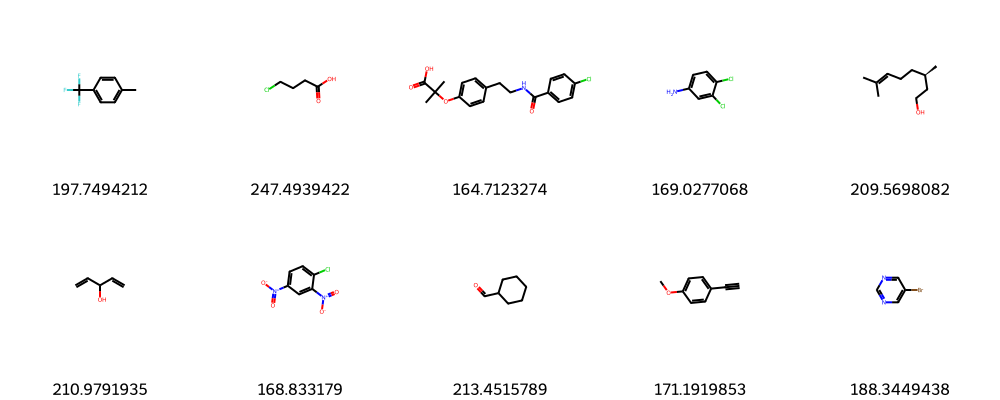

In [ ]:
#Lets Display the first 10 molecules (Structure)

Draw.MolsToGridImage(dataset["Structure"][:10],legends=[str(x) for x in dataset.Energygap], subImgSize=(200,200), molsPerRow=5)

**Function defination for generating Avalon molecular fingerprints using RDKit**

In [ ]:
#Lets write a function to generate the Avalon fingerprint

def generate_AVfpts(data):

  #store fingerprints using empty list Avalon_fpts =[]

  Avalon_fpts = []

  #Here, there is no need to generate mol files
  #We can directly use the structure column of the data frame
  # mols = [Chem.MolFromSmiles(x) for x in data if x is not none]

  for mol in tqdm(data):

    #calculate Avalon Fingerprints

      avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=4096)
      Avalon_fpts.append(avfpts)

  #append. Return the list as a numpy array
  return np.array(Avalon_fpts)

**Function Call to Generate Avalon Fingerprints of compounds in our dataset**


In [ ]:
#Function call

Avalon_fpts = generate_AVfpts(dataset['Structure'])

100%|██████████| 2904/2904 [00:02<00:00, 1227.56it/s]


**Now lets put the finferprints in dataframe**

In [ ]:
#Put generated Avalon fingerprints into data frame

Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1)
                                                        for i in range(Avalon_fpts.shape[1])])


In [ ]:
Avalon_fingerprints.head()

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_4087,Col_A_4088,Col_A_4089,Col_A_4090,Col_A_4091,Col_A_4092,Col_A_4093,Col_A_4094,Col_A_4095,Col_A_4096
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#This means we have 4096 features for each molecule

Now lets use LGBL to develop and train our model.
First, we need to initiate the model

In [ ]:
#Instantiate the models

lgbm_av = LGBMRegressor(n_estimators=800, random_state=42)
model_rf = RandomForestRegressor(random_state=42)

**10 fold cross-validation using 4096 bits of avalon fingerprints**

In [ ]:
# start time. I am only adding this time code to see how long it takes

start= time.time()

#tenfold cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
scoring = ['r2', 'neg_mean_absolute_error']

scores_val = cross_validate(lgbm_av, Avalon_fingerprints, dataset['Energygap'], cv=cv, scoring=scoring)

print (scores_val)

time.sleep(3)

#get end time
end = time.time()

#get the execution time
total_time = end - start

print ('Total time taken:', round(total_time/60, 2), 'min')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1024
[LightGBM] [Info] Start training from score 191.052642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1031
[LightGBM] [Info] Start training from score 190.942365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [ ]:
# R^2 of coefficient of determination of tenfold cross validation
scores_val['test_r2']

array([0.91044654, 0.90800796, 0.91153183, 0.92018218, 0.9045963 ,
       0.89865031, 0.90671041, 0.90788038, 0.89827042, 0.91485459])

In [ ]:
#Mean absolute error (MAE) of the tenfold cross validation values
-scores_val['test_neg_mean_absolute_error']

#As you can see from the previous output the MAE values were negative values.
# Hence i add a negative sign to make
# the values positive

array([5.79133628, 5.82072238, 5.86919926, 5.52286442, 6.21463951,
       6.16613145, 5.97132058, 6.12992087, 5.94971449, 5.76417806])

In [ ]:
#Mean values of tenfold cross-validation values of R^2 and MAE
#Using lightGBM

print('R^2:', round(np.mean(scores_val['test_r2']), 2))
print('MAE:', round(np.mean(-scores_val['test_neg_mean_absolute_error']), 2))

R^2: 0.91
MAE: 5.92


**Train-dest data split for Avalon Fingerprints**

In [ ]:
X_train_av, X_test_av, y_train_av, y_test_av = train_test_split(Avalon_fingerprints,
                                                                dataset['Energygap'], test_size=0.3, random_state=42)

In [ ]:
#Model training and test
model_av = lgbm_av.fit(X_train_av, y_train_av)
predict_av = model_av.predict(X_test_av)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 2032, number of used features: 1024
[LightGBM] [Info] Start training from score 191.052642


In [ ]:
#Model performance using MAE
MAE_av = mean_absolute_error(y_test_av, predict_av)
print('MAE:', round(MAE_av, 2))

MAE: 5.79


In [ ]:
#R^2 (coefficient of determination) regression score function:
R2_av = r2_score(y_test_av, predict_av)
print('R^2:', round(R2_av, 2))

R^2: 0.91


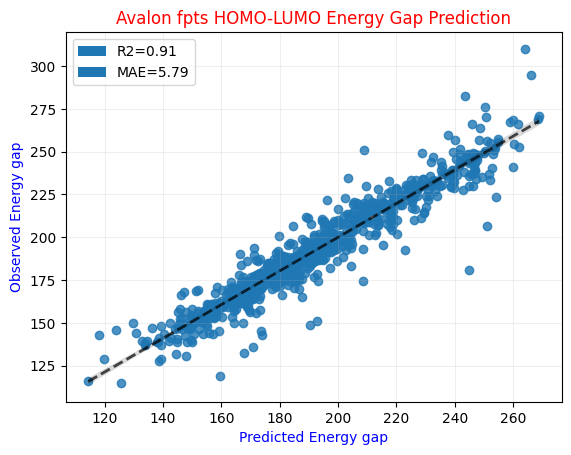

In [ ]:
sns.regplot(x=predict_av, y=y_test_av,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Avalon fpts HOMO-LUMO Energy Gap Prediction", color='red')
plt.grid(alpha=0.2)
R2_av = mpatches.Patch(label="R2={:04.2f}".format(R2_av))
MAE_av = mpatches.Patch(label="MAE={:04.2f}".format(MAE_av))
plt.legend(handles=[R2_av, MAE_av])